In [1]:
from proteinworkshop.features.factory import ProteinFeaturiser
from proteinworkshop.datasets.utils import create_example_batch
#from proteinworkshop.models.graph_encoders.schnet import SchNetModel
from torch.utils.data import Dataset
import pickle
import pdbreader
from torch.utils.data import DataLoader
import graphein.protein.tensor as gpt





/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


[11/26/23 20:46:41] DEBUG    No `.env` file found in project root. Checking for env vars...         ]8;id=221595;file:///home/max/.local/lib/python3.10/site-packages/proteinworkshop/constants.py\constants.py]8;;\:]8;id=684668;file:///home/max/.local/lib/python3.10/site-packages/proteinworkshop/constants.py#22\22]8;;\

                    DEBUG    No env var `DATA_PATH` found. Setting default...                       ]8;id=795317;file:///home/max/.local/lib/python3.10/site-packages/proteinworkshop/constants.py\constants.py]8;;\:]8;id=16966;file:///home/max/.local/lib/python3.10/site-packages/proteinworkshop/constants.py#28\28]8;;\

                    INFO     DATA_PATH:                                                             ]8;id=540397;file:///home/max/.local/lib/python3.10/site-packages/proteinworkshop/constants.py\constants.py]8;;\:]8;id=236344;file:///home/max/.local/lib/python3.10/site-packages/proteinworkshop/constants.py#39\39]8;;\
                             /home/max/.local/lib/python3.10/site-packages/proteinworkshop/data                    

In [3]:
with open("splits/prototype/train.pkl",'rb') as f:
    train = pickle.load(f)

with open("splits/prototype/val.pkl",'rb') as f:
    val = pickle.load(f)

with open("splits/prototype/test.pkl",'rb') as f:
    test = pickle.load(f)

trainnames = [x["id"] for x in train]
testnames = [x["id"] for x in test]
valnames = [x["id"] for x in val]

trainlabels = {}
for prot in train:
    trainlabels[prot["id"]]=prot["labels"]

vallabels = {}
for prot in val:
    vallabels[prot["id"]]=prot["labels"]

testlabels = {}
for prot in test:
    testlabels[prot["id"]]=prot["labels"]



create a label dicts for all sets

In [4]:
print(trainlabels["P10384"])

SSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBPPPPPPPPBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBPPPPPPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBPPPPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBBPPPPBBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBBPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBPPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBPP


In [5]:


# class transmembraneDataset(Dataset):
#     def __init__(self,data_li,path):
#         self.protein_names = [x["id"] for x in data_li]
#         self.residue_sequnces = [x["sequence"] for x in data_li]
#         self.label_sequences = [x["labels"] for x in data_li]        
#         self.pdb_path = path
        

#     def __len__(self):
#         return len(self.label_sequences)

#     def __getitem__(self,idx):
#         name = self.protein_names[idx]
#         pdb_file_path = self.pdb_path + name + ".pdb" #todo: read graph-tensor instead
#         pdb_file = pdbreader.read_pdb(pdb_file_path)
#         label = self.label_sequences[idx]
#         return name, pdb_file_path, label


# train_dataloader = DataLoader(transmembraneDataset(train,"data/graphein_downloads/train/"),batch_size=1,shuffle=True)


In [6]:
# name, path, label = next(iter(train_dataloader))
# print(name)
# print(path)
# print(label)

Test if we can throw it to PyG Data object

In [7]:
# data = gpt.io.protein_to_pyg(path=path[0],
#     chain_selection=["A", "B", "C", "D"], # Select all 4 chains
#     deprotonate=True, # Deprotonate the structure
#     keep_insertions=False, # Remove insertions
#     keep_hets=[], # Remove HETATMs
#     model_index=1, # Select the first model
#     # Can select a subset of atoms with atom_types=...
#     )

# protein = gpt.Protein().from_data(data)

In [8]:
# print(protein)

Create necessary batch attributes

```
def required_batch_attributes(self) -> Set[str]:
        """
        Required batch attributes for this encoder.

        - ``x``: Node features (shape: :math:`(n, d)`)
        - ``pos``: Node positions (shape: :math:`(n, 3)`)
        - ``edge_index``: Edge indices (shape: :math:`(2, e)`)
        - ``batch``: Batch indices (shape: :math:`(n,)`)

        :return: Set of required batch attributes
        :rtype: Set[str]
        """
        return {"pos", "edge_index", "x", "batch"}

```

In [9]:
# protein.batch = protein.coords
# protein.edges("knn_8",cache="edge_index")
# protein.pos = protein.coords[:,1,:]
# protein.x = protein.residue_type
# print(protein)


Batchify, load model and CA-featuriser

In [10]:
# batch = gpt.data.ProteinBatch().from_protein_list([protein])
# model = SchNetModel()
# featuriser = ProteinFeaturiser( #note: input is a protein Batch
#     representation="CA",
#     scalar_node_features=["amino_acid_one_hot"],
#     vector_node_features=[],
#     edge_types=["knn_16"],
#     scalar_edge_features=["edge_distance"],
#     vector_edge_features=[],
# )

# features_batch = featuriser(batch)

# output = model.forward(features_batch) #returns a dictionary 

In [11]:
# print(output.keys())


In [12]:
# print(output["node_embedding"].shape)
# print(output["graph_embedding"]) #im guessing this is hidden state 

So it seems to work. Now let's implement a PyG pipeline which does the same thing but with all the additional stuff included in the dataloader instance

In [4]:
from torch_geometric.data import Dataset as gDataset
from torch_geometric.loader import DataLoader
import glob
import os.path as osp
import torch 
from graphein.protein.utils import download_alphafold_structure
import os


torch.manual_seed(1)

class transmembraneGraphDataset(gDataset):
    """root: where the dataset should be stored"""
    def __init__(self, root, setType, proteinlist, labelDict, flush_files = False, transform=None, pre_transform=None,pre_filter=None):
        self.proteinlist = proteinlist
        self.conversionDict = {} #save data-conversion table between saved pt files and proteinnames
        self.root_local = root
        self.setType = setType
        self.labels = labelDict
        self.flush_files = flush_files
        print("self root local: ",self.root_local)
        print("protein list: ")
        print(self.proteinlist)
        #print("pdb dir: ",self.pdb_dir)
        super().__init__(root, transform, pre_transform, pre_filter)

    
    @property ##source directory of files - this is pdb-files in this case 
    def raw_file_names(self): #returns a list of all paths valid for entries in proteinlist
        #full_file_list = glob.glob(self.pdb_dir+"/*.pdb") #get all downloaded paths
        full_file_list = glob.glob(self.root_local+"raw/*.pdb") #get all downloaded paths
        
        #find matches so it matches the split
        res = list(
            set([sub1 for ele1 in full_file_list for sub1 in self.proteinlist if sub1 in ele1]))
        self.proteinlist = res #NOTE: OVERWRITES VALID FILES
        #res = [self.pdb_dir + x +".pdb" for x in res]
        #print(res)
        res = [x +".pdb" for x in res]
        #print("RESULTING RAW FILENAMES")
        #print(res)

        return res ###need to check it works when class is fully implemented

    @property
    def processed_file_names(self):
        #if we want to save as proteinid.pt
        #tmp = self.proteinlist
        #return [x.replace(".pdb",".pt") for x in tmp] #corresponding names with tensor extension
        return [self.setType+"_"+"protein_ "+ str(i) + ".pt" for i,_ in enumerate(self.proteinlist)]

    def download(self):    
        for protein_name in self.proteinlist:
            _ = download_alphafold_structure(protein_name, version=4,out_dir = self.root_local+"raw/", aligned_score=True)
        return
    
    def process(self):
        idx = 0
        #print("raw paths: ")
        #for raw_path in self.raw_paths: #this one adds a /raw/ for some reason
         #   print(raw_path)

        #print("Processed dir: ",self.processed_dir)
        all_files_tmp = glob.glob(osp.join(self.processed_dir, f'{self.setType}_protein_*.pt'))
        if(len(all_files_tmp)==len(self.proteinlist) and self.flush_files==False): ##case: all proteins are present
            print(f"Length of proteinnames {len(self.proteinlist)} is == to length of existing proteins in processed dir {len(all_files_tmp)}")
            return

        for i, raw_path in enumerate(self.raw_paths): #TODO: NEED TO IMPLEMENT THAT IF FILE ALREADY EXISTS, DON'T RUN PROCESS 
            print(f"running protein {i}/{len(self.raw_paths)} in set: {self.setType}")
            tmp_file_check = osp.join(self.processed_dir, f'{self.setType}_protein_{idx}.pt')
            if(os.path.isfile(tmp_file_check) and self.flush_files==False): #case: some files may already exist due to interruption of earlier command
                pass
            else:
                data = gpt.io.protein_to_pyg(path=raw_path,
                    chain_selection=["A", "B", "C", "D"], # Select all 4 chains
                    deprotonate=True, # Deprotonate the structure
                    keep_insertions=False, # Remove insertions
                    keep_hets=[], # Remove HETATMs
                    model_index=1) # Select the first model
                    # Can select a subset of atoms with atom_types=...
                
                #print(data)
                id = data["id"].replace("_ABCD","")#remove chain selection in naming for saving to dictionary
                #print("working on protein: f{id}")
                protein = gpt.Protein().from_data(data) #load protein from pdb-data
                #add edges etc
                protein.batch = protein.coords
                protein.edges("knn_8",cache="edge_index")
                protein.pos = protein.coords[:,1,:]
                protein.x = protein.residue_type
                #print(protein)
                if self.pre_filter is not None and not self.pre_filter(data):
                    continue

                if self.pre_transform is not None:
                    protein = self.pre_transform(protein)

                protein.label = self.labels[id] #fetch labelled sequence for the given protein and assign to graph-field
                
                protein = protein.to_data() #returns a torch geometric data object used for batching https://github.com/a-r-j/graphein/blob/master/graphein/protein/tensor/data.py#L266
                #save conversion for later reference in case all goes south
                self.conversionDict[id] = f'{self.setType}_protein_{idx}.pt'
                #print("the path join has arg:")
                #print(osp.join(self.processed_dir, f'protein_{idx}.pt'))
                torch.save(protein, osp.join(self.processed_dir, f'{self.setType}_protein_{idx}.pt'))
            idx += 1
            #if(idx==10): #for debugging
            #    return
        
    def len(self):
        return len(self.processed_file_names)

    def get(self,idx):
        data = torch.load(osp.join(self.processed_dir, f'{self.setType}_protein_{idx}.pt'))
        #need to also return labels for the given protein
        return data
    
    def get_protein_label_dict(self):
        return self.labels


#let's try generating the tensor data-set and see what happens
pdb_dir = "./data/graphein_downloads/v4/" #downloaded using AFv4
trainGraphDataloader = transmembraneGraphDataset(root=pdb_dir,setType="train",proteinlist=trainnames,labelDict=trainlabels)
#valGraphDataloader = transmembraneGraphDataset(root=pdb_dir,setType="val",proteinlist=valnames,labelDict=vallabels)
#testGraphDataloader = transmembraneGraphDataset(root=pdb_dir,setType="test",proteinlist=testnames,labelDict=testlabels)

train_label_dict = trainGraphDataloader.get_protein_label_dict()
#val_label_dict = valGraphDataloader.get_protein_label_dict()
#test_label_dict = testGraphDataloader.get_protein_label_dict()


self root local:  ./data/graphein_downloads/v4/
protein list: 
['P10384', 'P0ABU7', 'Q55210', 'Q5XKL5', 'Q9KDP2', 'Q9CC87', 'Q7TQM5', 'Q2YDF6', 'P10163', 'Q12286', 'Q0P9C4', 'Q9SIW2', 'P10257', 'Q9USW9', 'P50580', 'Q9UHW9', 'A0A0K3AUE4', 'Q9MV14', 'Q25255', 'Q9US51', 'P17558', 'O31284', 'Q9VSK8', 'P28611', 'F4JN26', 'Q8N474', 'P07305', 'Q8L719', 'P10745', 'K4D422', 'P0AG96', 'Q01172', 'Q18412', 'P38777', 'O42914', 'P49146', 'Q68XS6', 'Q5FBB7', 'Q62414', 'Q10Q07', 'P21554', 'Q9UU87', 'E9K9Z1', 'P40518', 'Q12287', 'Q32MW3', 'B3U538', 'P54498', 'P9WG65', 'Q06506', 'Q8IWU4', 'C1B1D9', 'Q9D4W2', 'Q08561', 'A0A0B9X9I7', 'Q97WX4', 'Q7CGI0', 'P87176', 'Q96FM1', 'Q5A5Q6', 'C7G3K3', 'P21826', 'Q9LU68', 'P0AC98', 'O34344', 'P09038', 'O14131', 'Q9FKB3', 'P13385', 'Q9H293', 'C4IN73', 'P01019', 'O83077', 'Q54GH3', 'P52927', 'P42586', 'P21978', 'Q9EYW6', 'P38852', 'P37648', 'P0A8Q0', 'Q9HDZ6', 'Q5E2P0', 'Q10424', 'P15289', 'Q2V3L3', 'P38439', 'Q10356', 'P51688', 'O74544', 'Q15722', 'P55046', 'Q7TSH3'

Processing...
Done!


In [5]:
batch = trainGraphDataloader.get(0)
print(batch)
print(len(batch.label))

FileNotFoundError: [Errno 2] No such file or directory: 'data/graphein_downloads/v4/processed/train_protein_0.pt'

In [205]:
trainloader = DataLoader(trainGraphDataloader,batch_size=1,shuffle=False)

In [206]:
batch = next(iter(trainloader))
print(batch)

DataBatch(coords=[269, 37, 3], chains=[269], batch=[269], label=[1], residue_id=[1], residues=[1], pos=[269, 3], id=[1], x=[269], residue_type=[269], edge_index=[2, 2152], atom_list=[1], fill_value=[1], ptr=[2])


In [17]:
# class transmembraneDataset(Dataset):
#     def __init__(self,data_li,path):
#         self.protein_names = [x["id"] for x in data_li]
#         self.residue_sequnces = [x["sequence"] for x in data_li]
#         self.label_sequences = [x["labels"] for x in data_li]        
#         self.pdb_path = path
        

#     def __len__(self):
#         return len(self.label_sequences)

#     def __getitem__(self,idx):
#         name = self.protein_names[idx]
#         #pdb_file_path = self.pdb_path + name + ".pdb" #todo: read graph-tensor instead
        
#         #pdb_file = pdbreader.read_pdb(pdb_file_path)
#         filePath = self.pdb_path + name + ".pdb"
#         protein = gpt.io.protein_to_pyg(path=filePath, #read to pytorch geometric tensor
#             chain_selection=["A", "B", "C", "D"], # Select all 4 chains
#             deprotonate=True, # Deprotonate the structure
#             keep_insertions=False, # Remove insertions
#             keep_hets=[], # Remove HETATMs
#             model_index=1, # Select the first model
#         )
#         label = self.label_sequences[idx]
#         return name, protein, label

Test a forward

First, define SchNetModel completely as given in the file 

In [6]:
from typing import Optional, Set, Union

import torch
import torch_scatter
from graphein.protein.tensor.data import ProteinBatch
from torch_geometric.data import Batch
from torch_geometric.nn.models import SchNet

from proteinworkshop.types import EncoderOutput


class SchNetModel(SchNet):
    #default values overwritten by cfg default settings
    def __init__(
        self,
        hidden_channels: int = 512,#128,#512,#128,
        out_dim: int = 32,#1,
        num_filters: int = 128,
        num_layers: int = 6,
        num_gaussians: int = 50,
        cutoff: float = 10,
        max_num_neighbors: int = 32,
        readout: str = "add",
        dipole: bool = False,
        mean: Optional[float] = None,
        std: Optional[float] = None,
        atomref: Optional[torch.Tensor] = None,
        pretrained = False
    ):
        """
        Initializes an instance of the SchNetModel class with the provided
        parameters.

        :param hidden_channels: Number of channels in the hidden layers
            (default: ``128``)
        :type hidden_channels: int
        :param out_dim: Output dimension of the model (default: ``1``)
        :type out_dim: int
        :param num_filters: Number of filters used in convolutional layers
            (default: ``128``)
        :type num_filters: int
        :param num_layers: Number of convolutional layers in the model
            (default: ``6``)
        :type num_layers: int
        :param num_gaussians: Number of Gaussian functions used for radial
            filters (default: ``50``)
        :type num_gaussians: int
        :param cutoff: Cutoff distance for interactions (default: ``10``)
        :type cutoff: float
        :param max_num_neighbors: Maximum number of neighboring atoms to
            consider (default: ``32``)
        :type max_num_neighbors: int
        :param readout: Global pooling method to be used (default: ``"add"``)
        :type readout: str
        """
        super().__init__(
            hidden_channels,
            num_filters,
            num_layers,
            num_gaussians,
            cutoff,  # None, # Interaction graph is not used
            max_num_neighbors,
            readout,
            dipole,
            mean,
            std,
            atomref,
        )
        self.readout = readout
        # Overwrite embbeding
        self.embedding = torch.nn.LazyLinear(hidden_channels)
        # Overwrite atom embedding and final predictor
        self.lin2 = torch.nn.LazyLinear(out_dim)

        #self.decoder 

    @property
    def required_batch_attributes(self) -> Set[str]:
        """
        Required batch attributes for this encoder.

        - ``x``: Node features (shape: :math:`(n, d)`)
        - ``pos``: Node positions (shape: :math:`(n, 3)`)
        - ``edge_index``: Edge indices (shape: :math:`(2, e)`)
        - ``batch``: Batch indices (shape: :math:`(n,)`)

        :return: Set of required batch attributes
        :rtype: Set[str]
        """
        return {"pos", "edge_index", "x", "batch"}

    def forward(self, batch: Union[Batch, ProteinBatch]) -> EncoderOutput:
        """Implements the forward pass of the SchNet encoder.

        Returns the node embedding and graph embedding in a dictionary.

        :param batch: Batch of data to encode.
        :type batch: Union[Batch, ProteinBatch]
        :return: Dictionary of node and graph embeddings. Contains
            ``node_embedding`` and ``graph_embedding`` fields. The node
            embedding is of shape :math:`(|V|, d)` and the graph embedding is
            of shape :math:`(n, d)`, where :math:`|V|` is the number of nodes
            and :math:`n` is the number of graphs in the batch and :math:`d` is
            the dimension of the embeddings.
        :rtype: EncoderOutput
        """
        h = self.embedding(batch.x)

        u, v = batch.edge_index
        edge_weight = (batch.pos[u] - batch.pos[v]).norm(dim=-1)
        edge_attr = self.distance_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, batch.edge_index, edge_weight, edge_attr)

        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        #add the decoder task

        return EncoderOutput(
            {
                "node_embedding": h,
                "graph_embedding": torch_scatter.scatter(
                    h, batch.batch, dim=0, reduce=self.readout
                ),
            }
        )


# if __name__ == "__main__":
#     import hydra
#     import omegaconf
#     import pyrootutils
#     from graphein.protein.tensor.data import get_random_protein

#     root = pyrootutils.setup_root(__file__, pythonpath=True)
#     cfg = omegaconf.OmegaConf.load(
#         root / "configs" / "encoder" / "schnet.yaml"
#     )
#     print(cfg)
#     encoder = hydra.utils.instantiate(cfg.schnet)
#     print(encoder)
#     batch = ProteinBatch().from_protein_list(
#         [get_random_protein() for _ in range(4)], follow_batch=["coords"]
#     )
#     batch.batch = batch.coords_batch
#     batch.edges("knn_8", cache="edge_index")
#     batch.pos = batch.coords[:, 1, :]
#     batch.x = batch.residue_type
#     print(batch)
#     out = encoder.forward(batch)
#     print(out)

In [350]:
model = SchNetModel()

featuriser = ProteinFeaturiser( #note: input is a protein Batch
    representation="CA",
    scalar_node_features=["amino_acid_one_hot"],
    vector_node_features=[],
    edge_types=["knn_16"],
    scalar_edge_features=["edge_distance"],
    vector_edge_features=[],
)

#batch = next(iter(trainloader))
print(batch.keys())
print("coords shape: ", batch["coords"].shape)
print("protein ids: ",batch["id"])
print("with shape: ",len(batch["id"]))
batch_featurised = featuriser(batch)
out_test = model.forward(batch_featurised)
print(out_test)


['edge_index', 'batch', 'id', 'fill_value', 'residue_id', 'num_relation', 'atom_list', 'residues', 'edge_attr', 'label', 'edge_type', 'coords', 'chains', 'x', 'pos', 'residue_type', 'ptr']
coords shape:  torch.Size([269, 37, 3])
protein ids:  ['Q8Z6A7_ABCD']
with shape:  1
{'node_embedding': tensor([[-0.0482,  0.0966,  0.0428,  ...,  0.0797,  0.0044, -0.0006],
        [ 0.0196, -0.0141,  0.0707,  ...,  0.0954, -0.0315,  0.0449],
        [ 0.0259, -0.0199,  0.0726,  ...,  0.0929, -0.0278,  0.0409],
        ...,
        [-0.0182, -0.0030,  0.1388,  ...,  0.0874, -0.0682,  0.0039],
        [ 0.0239,  0.0733,  0.0729,  ...,  0.0781, -0.0121,  0.0852],
        [-0.0180,  0.0720, -0.0392,  ...,  0.1198, -0.0626,  0.0218]],
       grad_fn=<AddmmBackward0>), 'graph_embedding': tensor([[  3.8226,   8.4874,  22.5619,  -6.2671, -14.9207,   2.7266, -14.9714,
           4.7564, -41.5628, -21.8096,  24.4202, -16.0367, -25.0720, -19.4587,
         -11.4167,  18.6298,  19.4782, -10.7276, -13.4611,  14

/home/max/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



In [209]:
print(out_test.keys())

dict_keys(['node_embedding', 'graph_embedding'])


In [210]:
print(out_test["node_embedding"].shape)
print(out_test["graph_embedding"].shape) #so this is the same size as the batch 

torch.Size([269, 32])
torch.Size([1, 32])


In [211]:
print(model)

SchNetModel(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10)


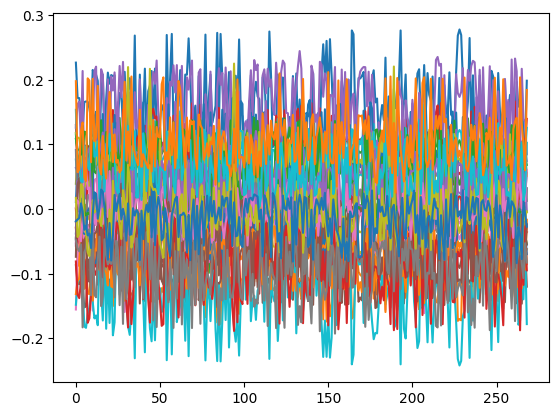

In [212]:
import matplotlib.pyplot as plt 

plt.plot(out_test["node_embedding"].detach().numpy())

In [213]:
print(batch.keys())

['edge_index', 'batch', 'id', 'fill_value', 'residue_id', 'num_relation', 'atom_list', 'residues', 'edge_attr', 'label', 'edge_type', 'coords', 'chains', 'x', 'pos', 'residue_type', 'ptr']


In [214]:
ge = out_test["graph_embedding"]
ne = out_test["node_embedding"]

In [215]:
print(ne.shape)

torch.Size([269, 32])


Does the output format change when using a proteinbatch? 

In [217]:
print(model.forward(gpt.data.ProteinBatch().from_batch(batch_featurised))) #absolutely the same, so no reason to use it 

{'node_embedding': tensor([[ 0.2265, -0.0288, -0.0458,  ...,  0.1535, -0.0189,  0.1978],
        [ 0.1720, -0.0885,  0.0113,  ...,  0.0765, -0.0162,  0.0569],
        [ 0.1716, -0.0829,  0.0140,  ...,  0.0747, -0.0138,  0.0616],
        ...,
        [ 0.1009, -0.0251, -0.0209,  ...,  0.0124,  0.0116,  0.0998],
        [ 0.1011, -0.0689, -0.0406,  ...,  0.0269, -0.0082,  0.0600],
        [ 0.1985, -0.0619, -0.0541,  ...,  0.1024, -0.0272,  0.1841]],
       grad_fn=<AddmmBackward0>), 'graph_embedding': tensor([[ 44.8822, -10.6955,  -3.4998,  25.6571,  40.5391, -16.7218,  -2.0870,
          -4.8737,  -7.4975,  18.3336,  21.9508, -28.1488,  24.5794,  -4.7469,
          20.0342, -26.4512, -10.2969,   4.0057,  19.8621, -36.6688,  -3.2988,
         -19.3582,  13.8399, -24.3971,  10.8329, -13.4576,  -0.1191, -25.2808,
          -2.9359,  19.0399,  -4.0137,  29.1482]],
       grad_fn=<ScatterAddBackward0>)}


No :)

Make encoder decoder model 


In [607]:
#from torch.nn import linear
from graphein.protein.tensor.data import get_random_protein
from proteinworkshop.datasets.utils import create_example_batch

class DenseDecoder(torch.nn.Module):
   def __init__(self,n_classes=6,hidden_dim = 32):
      super(DenseDecoder, self).__init__()
      #self.linear1 = linear(in_features=20,out_channels=n_classes)
      self.ll = torch.nn.Linear(hidden_dim,n_classes,bias=True)
   def forward(self,x):
      #print("Decoder layer received a shape: ",x["node_embedding"].shape)
      return self.ll(x["node_embedding"])

class LSTMDecoder(torch.nn.Module):
   def __init__(self,n_classes=6, GCN_hidden_dim = 32, LSTM_hidden_dim = 32, dropout = 0.0, type="LSTMO"):
      super(LSTMDecoder, self).__init__()
      #self.linear1 = linear(in_features=20,out_channels=n_classes)
      if(type=="LSTMO"):
         bid = False
         self.proj = torch.nn.Linear(LSTM_hidden_dim,n_classes) #project to per class sequence
      elif(type=="LSTMB"):
         bid = True
         self.proj = torch.nn.Linear(LSTM_hidden_dim*2,n_classes) #project to per class sequence
      self.LSTM = torch.nn.LSTM(input_size = GCN_hidden_dim,hidden_size=LSTM_hidden_dim,dropout=dropout,bidirectional=bid)
      

      self.init_LSTM()

   def init_LSTM(self):
      for weight in self.LSTM._all_weights:
         if("weight" in weight):
            nn.init.xavier_normal_(getattr(self.LSTM,weight))
         if("bias" in weight):
            nn.init.normal_(getattr(self.LSTM,weight))

   def forward(self,x):
      lstmoutput,state = self.LSTM(x["node_embedding"])
      #print("lstmoutput ", lstmoutput.shape)
      #print("state 0 shape: ",state[0].shape)
      #print("state 1 shape: ",state[1].shape)
      out = self.proj(lstmoutput)
      return out

def init_linear_weights(m):
   if isinstance(m, torch.nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      
class GraphEncDec(torch.nn.Module):
   def __init__(self,featuriser,n_classes=6,hidden_dim_GCN = 32, decoderType="linear", LSTM_hidden_dim = 0, dropout = 0.0):
      #do all necessary init stuff.
      super(GraphEncDec,self).__init__()
      self.encoder = SchNetModel(out_dim=hidden_dim_GCN)
      self.featuriser = featuriser
      self.init_lazy_layers()  #initialize weights of LazyLinear layers by forwarding a random batch 
      if(decoderType=="linear"):
         self.decoder =  DenseDecoder(n_classes=n_classes,hidden_dim=hidden_dim_GCN)
      elif(decoderType!="linear"): #one directional LSTM
         self.decoder = LSTMDecoder(n_classes=n_classes,GCN_hidden_dim=hidden_dim_GCN, LSTM_hidden_dim = LSTM_hidden_dim, dropout = dropout, type=decoderType)

      self.softmax = torch.nn.Softmax(dim=1) 
      
   def init_lazy_layers(self):
      example_batch = create_example_batch()
      _ = self.encoder(self.featuriser(example_batch))
      return 
  
   def forward(self,X):
      embeddings = self.encoder(self.featuriser(X)) #returns a dict containing node_embedding and node_encoding
      predictions = self.decoder(embeddings)
      return predictions
    
   def predict(self,X):
      preds = self.forward(self.featuriser(X))
      sm = self.softmax(preds)
      return torch.argmax(sm,dim=1)
        


In [553]:
def label_to_tensor(labels,type2key):
    """
    Encodes corresponding numeric labels to residue cell-position
    Input: 
        label: a list. Length of list indicates the number of samples in the batch 
    """
    #unbatch by creating large string
    collated_str = ""
    for protein_label in labels: 
        collated_str += protein_label

    collated_char_li = [*collated_str]
    #print(chars)
    default = "UNK"
    output = [type2key.get(x, default) for x in collated_char_li]
    output = torch.as_tensor(output)
    #from torch.nn.functional import one_hot
    #return one_hot(output,num_classes = len(type2key))
    return output

type2key = {"S":0,"I":1,"M":2,"B":3,"P":4,"O":5} 
print(label_to_tensor(batch_featurised.label,type2key))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5])


Let's see if we can overfit a small subset of 16 training samples with batches of two to also establish batch-support

In [608]:
#lets train the model for 10 epochs using softmax and the labels
pdb_dir = "./data/graphein_downloads/v4/" #downloaded using AFv4
trainSet = transmembraneGraphDataset(root=pdb_dir,setType="train",proteinlist=trainnames,labelDict=trainlabels)
valSet = transmembraneGraphDataset(root=pdb_dir,setType="val",proteinlist=valnames,labelDict=vallabels)
testSet = transmembraneGraphDataset(root=pdb_dir,setType="test",proteinlist=testnames,labelDict=testlabels)

train_label_dict = trainSet.get_protein_label_dict()
val_label_dict = valSet.get_protein_label_dict()
test_label_dict = testSet.get_protein_label_dict()


self root local:  ./data/graphein_downloads/v4/
protein list: 
['P10384', 'P0ABU7', 'Q55210', 'Q5XKL5', 'Q9KDP2', 'Q9CC87', 'Q7TQM5', 'Q2YDF6', 'P10163', 'Q12286', 'Q0P9C4', 'Q9SIW2', 'P10257', 'Q9USW9', 'P50580', 'Q9UHW9', 'A0A0K3AUE4', 'Q9MV14', 'Q25255', 'Q9US51', 'P17558', 'O31284', 'Q9VSK8', 'P28611', 'F4JN26', 'Q8N474', 'P07305', 'Q8L719', 'P10745', 'K4D422', 'P0AG96', 'Q01172', 'Q18412', 'P38777', 'O42914', 'P49146', 'Q68XS6', 'Q5FBB7', 'Q62414', 'Q10Q07', 'P21554', 'Q9UU87', 'E9K9Z1', 'P40518', 'Q12287', 'Q32MW3', 'B3U538', 'P54498', 'P9WG65', 'Q06506', 'Q8IWU4', 'C1B1D9', 'Q9D4W2', 'Q08561', 'A0A0B9X9I7', 'Q97WX4', 'Q7CGI0', 'P87176', 'Q96FM1', 'Q5A5Q6', 'C7G3K3', 'P21826', 'Q9LU68', 'P0AC98', 'O34344', 'P09038', 'O14131', 'Q9FKB3', 'P13385', 'Q9H293', 'C4IN73', 'P01019', 'O83077', 'Q54GH3', 'P52927', 'P42586', 'P21978', 'Q9EYW6', 'P38852', 'P37648', 'P0A8Q0', 'Q9HDZ6', 'Q5E2P0', 'Q10424', 'P15289', 'Q2V3L3', 'P38439', 'Q10356', 'P51688', 'O74544', 'Q15722', 'P55046', 'Q7TSH3'

Processing...
Done!


Length of proteinnames 2129 is == to length of existing proteins in processed dir 2129
self root local:  ./data/graphein_downloads/v4/
protein list: 
['I6S7G5', 'Q9FGT8', 'Q64514', 'Q9Z0G9', 'P59665', 'Q9JJW5', 'O15297', 'Q13162', 'P12238', 'Q05471', 'O74562', 'Q5XPI4', 'P50222', 'Q3MUH7', 'P0DI81', 'Q48754', 'Q8N9V6', 'Q24322', 'Q9VYY9', 'Q08816', 'Q3L8N0', 'P37655', 'O97148', 'P55734', 'P26461', 'Q86W54', 'Q51227', 'Q9UL49', 'O76818', 'P09914', 'P82130', 'P07255', 'P44572', 'D4GW40', 'Q54735', 'Q01613', 'P9WNQ9', 'G5EGA3', 'Q4V4I9', 'Q9BDB7', 'Q9FMB4', 'A1XBS5', 'P28325', 'O35387', 'Q6R0G4', 'Q83EK8', 'O74312', 'P24821', 'Q9LZ56', 'Q23997', 'O74458', 'P63235', 'Q8LGD5', 'Q7KHG2', 'P84810', 'Q13112', 'Q9Z4S6', 'O94598', 'O82312', 'Q9BQB4', 'Q10137', 'A8K830', 'Q03188', 'Q9FX45', 'P0A6M2', 'B7MBF8', 'E3PPC4', 'Q9KPQ4', 'Q78IQ7', 'P9WK69', 'O14141', 'Q02354', 'A6W1C5', 'O60303', 'Q92542', 'Q9CKU6', 'Q9R1C0', 'O82239', 'P08751', 'Q09601', 'Q9Y4X3', 'P06700', 'O70576', 'P0CX78', 'Q5ZKX9',

Processing...
Done!


Length of proteinnames 704 is == to length of existing proteins in processed dir 704
self root local:  ./data/graphein_downloads/v4/
protein list: 
['Q59514', 'Q8K4G5', 'P93045', 'P32051', 'P9WP57', 'P48612', 'Q8TD19', 'P30659', 'P03934', 'P05146', 'P40032', 'P50528', 'Q9NZN9', 'Q476F7', 'O08648', 'A2VBC4', 'Q8NFK1', 'P47924', 'Q8LKS5', 'P02879', 'Q08119', 'P52554', 'P22266', 'Q9LT15', 'Q8NJU8', 'Q88NC7', 'O01510', 'Q6L545', 'O42924', 'P35874', 'P0AD59', 'Q54WR4', 'Q8NBZ0', 'P70060', 'Q5BGU9', 'P00424', 'Q9USH2', 'O21043', 'Q8L6J3', 'P13727', 'Q9SU05', 'A5W3Z9', 'G5EC68', 'Q95Y36', 'Q59675', 'Q9UTR8', 'P0AFF0', 'P53867', 'Q8RLX0', 'Q9UBS5', 'Q4G0N4', 'Q4KL25', 'P21524', 'Q588Z1', 'Q9ST62', 'P00144', 'Q8NFH5', 'O60055', 'Q7Z6K1', 'Q9I4Z4', 'Q9LTB0', 'P05743', 'B6TTV8', 'P64428', 'P0AFM2', 'O88093', 'Q9NRD9', 'O14773', 'Q93Z81', 'Q15814', 'Q91VR5', 'Q00196', 'P54107', 'P55197', 'Q91V10', 'Q87RN6', 'O36023', 'Q10NX8', 'P40099', 'Q9VSL7', 'O60565', 'E5FYH0', 'P58557', 'Q99593', 'P00652', '

Processing...
Done!


Setup experiment

In [609]:

trainSubset = torch.utils.data.Subset(trainSet,list(range(0,32))) #logs in obsidian
trainloader = DataLoader(trainSubset,batch_size=4,shuffle=True)

featuriser = ProteinFeaturiser( #note: input is a protein Batch
         representation="CA",
         scalar_node_features=["amino_acid_one_hot"],
         vector_node_features=[],
         edge_types=["knn_16"],
         scalar_edge_features=["edge_distance"],
         vector_edge_features=[],
      )
model = GraphEncDec(featuriser=featuriser, n_classes=6,hidden_dim_GCN=64,decoderType="LSTMB",LSTM_hidden_dim=16,dropout=0.0)   

model.apply(init_linear_weights) #change to xavier normal init
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train_single_epoch():
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader):
        #print(data)
        optimizer.zero_grad()
        output = model(data)
        label = label_to_tensor(data.label,type2key)
        #print(output.shape)
        #print(torch.argmax(output,dim=1))
        #print(type(output))
        #print(label.shape)
        #print(type(label))
        #print(output)
        #print(label)
        #print(len(label))
        #print(output.shape)
        #print(output)
        #print("Output shape: ", output.shape)
        #print("Label shape: ",label.shape)
        loss = criterion(output,label) #no need to worry about batching as graph is disjoint by design -> in principle no batching
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss/len(trainloader), output #return average epoch loss and output for the last batch  - should not be constant from start till end if learning

In [610]:
N_EPOCHS = 200
epoch_loss = []
outputs = []
print_every = 10

#before training prediction
test_sample = next(iter(trainloader))

pred_before = model.predict(test_sample)


for i in range(N_EPOCHS):
    loss, output = train_single_epoch()
    epoch_loss.append(loss)
    outputs.append(output)
    if(i%print_every==0):
        print(f"Loss in epoch {i}: {loss}")

pred_after = model.predict(test_sample)

Loss in epoch 0: 1.172430895268917
Loss in epoch 3: 0.6907193958759308
Loss in epoch 6: 0.780565906316042
Loss in epoch 9: 0.7775790896266699
Loss in epoch 12: 0.6653125993907452
Loss in epoch 15: 0.6756054982542992
Loss in epoch 18: 0.6892291195690632
Loss in epoch 21: 0.6730056069791317
Loss in epoch 24: 0.7673834711313248
Loss in epoch 27: 0.6837658733129501
Loss in epoch 30: 0.6164772361516953
Loss in epoch 33: 0.6734523512423038
Loss in epoch 36: 0.6309424638748169
Loss in epoch 39: 0.6343958899378777
Loss in epoch 42: 0.7265823297202587
Loss in epoch 45: 0.6709261238574982


KeyboardInterrupt: 

tensor(0.0259)


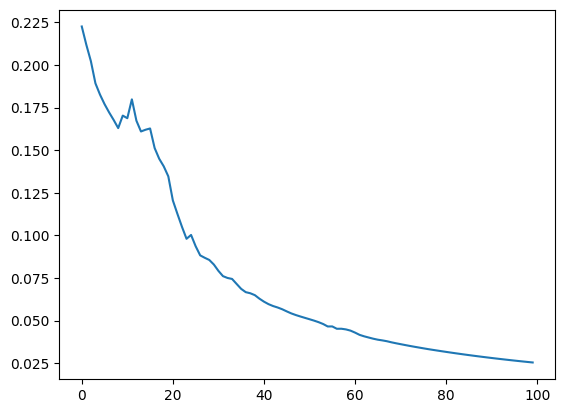

In [603]:
import matplotlib.pyplot as plt 
import numpy as np 

#plt.plot(np.arange(1,N_EPOCHS+1,1),epoch_loss)
plt.plot(epoch_loss)
print(torch.mean(torch.Tensor(epoch_loss[-5:])))


In [604]:
print("prediction before training: ", pred_before)
print("prediction after training: ", pred_after)
label = label_to_tensor(test_sample.label,type2key)
print("Ground truth label: ", label)

prediction before training:  tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5])
prediction after training:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [612]:
def get_accuracy_single_sample(prediction,label):
    correct = torch.sum((prediction==label))
    incorrect = torch.sum((prediction!=label))
    return correct/(correct+incorrect)

#
#print(get_accuracy_single_sample(model.predict(test_sample),label))

def dataset_accuracy(model,dataloader):
    model.eval()
    correct = 0
    incorrect = 0
    for i, data in enumerate(dataloader):
        preds = model.predict(data)
        label = label_to_tensor(data.label,type2key)
        correct += torch.sum((preds==label))
        incorrect += torch.sum((preds!=label))

    return correct/(correct+incorrect)

print("Complete training set accuracy: ",dataset_accuracy(model,trainloader))




Complete training set accuracy:  tensor(0.7869)


In [251]:
print(outputs[-1])
print(outputs[0])

tensor([[-0.0980, -0.0794,  0.1388, -0.0590,  0.2122,  0.1284],
        [-0.1134, -0.0764,  0.1752, -0.1219,  0.2185,  0.1465],
        [-0.0917, -0.0604,  0.1741, -0.1042,  0.2073,  0.1519],
        ...,
        [-0.1016, -0.0598,  0.1574, -0.0925,  0.2087,  0.1687],
        [-0.0911, -0.0605,  0.1786, -0.1064,  0.2105,  0.1519],
        [-0.1073, -0.0735,  0.1512, -0.0913,  0.2015,  0.1514]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0986, -0.0832,  0.1439, -0.0597,  0.2128,  0.1276],
        [-0.1079, -0.0629,  0.1520, -0.1151,  0.1685,  0.1239],
        [-0.1370, -0.0570,  0.1232, -0.0707,  0.2092,  0.1149],
        ...,
        [-0.1355, -0.0575,  0.1268, -0.0691,  0.2092,  0.1123],
        [-0.0907, -0.0653,  0.1816, -0.1080,  0.2062,  0.1540],
        [-0.0905, -0.0682,  0.1809, -0.1045,  0.2075,  0.1508]],
       grad_fn=<AddmmBackward0>)


In [249]:
baseline_crossentropy = lambda N: -torch.log(torch.Tensor([1/N])).item()
print(f"The baseline random loss is expected to be {baseline_crossentropy(6)}")

The baseline random loss is expected to be 1.7917594909667969


In [133]:
print(results_hook[0][0,:])
print(results_hook[-1][0,:])
softmax = torch.nn.Softmax(dim=1) #already part of crossentropy loss 
softmax(results_hook[-1])

tensor([ 0.1272,  0.1525, -0.0666, -0.2506, -0.0939,  0.1303],
       grad_fn=<SliceBackward0>)
tensor([ 0.1843, -2.5470, -0.8269, -3.0535, -2.7179,  4.2263],
       grad_fn=<SliceBackward0>)


tensor([[1.7106e-02, 1.1141e-03, 6.2225e-03, 6.7138e-04, 9.3910e-04, 9.7395e-01],
        [1.7668e-02, 1.1866e-03, 6.4979e-03, 7.1372e-04, 1.0004e-03, 9.7293e-01],
        [1.7686e-02, 1.1887e-03, 6.5057e-03, 7.1500e-04, 1.0022e-03, 9.7290e-01],
        ...,
        [1.4580e-02, 8.3907e-04, 5.1503e-03, 5.0537e-04, 7.1009e-04, 9.7822e-01],
        [1.6574e-02, 1.0470e-03, 5.9827e-03, 6.3110e-04, 8.8282e-04, 9.7488e-01],
        [1.6605e-02, 1.0571e-03, 6.0301e-03, 6.4134e-04, 8.9595e-04, 9.7477e-01]],
       grad_fn=<SoftmaxBackward0>)

In [136]:
#now evaluate
softmax = torch.nn.Softmax(dim=1) #already part of crossentropy loss 
mod.eval()
output = softmax(mod(batch_featurised))
print(output)
classification = torch.argmax(output,dim=1)
print("Model classification: ",classification)
print("True label: ",label)

tensor([[0.0725, 0.0113, 0.0112, 0.0114, 0.0114, 0.8822],
        [0.0722, 0.0113, 0.0111, 0.0113, 0.0113, 0.8829],
        [0.0722, 0.0113, 0.0111, 0.0113, 0.0113, 0.8829],
        ...,
        [0.0661, 0.0096, 0.0095, 0.0097, 0.0096, 0.8956],
        [0.0695, 0.0105, 0.0104, 0.0106, 0.0105, 0.8885],
        [0.0709, 0.0109, 0.0107, 0.0109, 0.0109, 0.8857]],
       grad_fn=<SoftmaxBackward0>)
Model classification:  tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 